We trained our CNN on Google Colab using the A100 GPU

In [ ]:
import kagglehub

path = kagglehub.dataset_download("shiekhburhan/face-mask-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.33G/2.33G [02:08<00:00, 19.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shiekhburhan/face-mask-dataset/versions/1


In [ ]:
from google.colab import drive
import zipfile
import os


drive.mount('/content/drive')


zip_file_path = "/content/drive/My Drive/archive.zip"
extracted_folder_path = "/content/archive_extracted"


os.makedirs(extracted_folder_path, exist_ok=True)


try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_folder_path)
    print("Extraction complete!")
except Exception as e:
    print(f"Error during extraction: {e}")


Mounted at /content/drive
Extraction complete!


In [ ]:
for root, dirs, files in os.walk(extracted_folder_path):
    print(f"Directory: {root}, Number of files: {len(files)}")

Directory: /content/archive_extracted, Number of files: 0
Directory: /content/archive_extracted/FMD_DATASET, Number of files: 0
Directory: /content/archive_extracted/FMD_DATASET/incorrect_mask, Number of files: 0
Directory: /content/archive_extracted/FMD_DATASET/incorrect_mask/mmc, Number of files: 2500
Directory: /content/archive_extracted/FMD_DATASET/incorrect_mask/mc, Number of files: 2500
Directory: /content/archive_extracted/FMD_DATASET/without_mask, Number of files: 0
Directory: /content/archive_extracted/FMD_DATASET/without_mask/complex, Number of files: 747
Directory: /content/archive_extracted/FMD_DATASET/without_mask/simple, Number of files: 4000
Directory: /content/archive_extracted/FMD_DATASET/with_mask, Number of files: 0
Directory: /content/archive_extracted/FMD_DATASET/with_mask/complex, Number of files: 789
Directory: /content/archive_extracted/FMD_DATASET/with_mask/simple, Number of files: 4000


In [ ]:
import shutil
from sklearn.model_selection import train_test_split


base_dir = "/content/archive_extracted/FMD_DATASET"
organized_dir = "/content/organized_dataset"


os.makedirs(organized_dir, exist_ok=True)


categories = {
    "incorrect_mask": ["mmc", "mc"],
    "without_mask": ["complex", "simple"],
    "with_mask": ["complex", "simple"]
}


train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1


def organize_category(category_name, subdirs):
    category_path = os.path.join(base_dir, category_name)
    all_images = []
    for subdir in subdirs:
        subdir_path = os.path.join(category_path, subdir)
        images = [os.path.join(subdir_path, img) for img in os.listdir(subdir_path) if img.endswith(('.jpg', '.png', '.jpeg'))]
        all_images.extend(images)


    train_data, temp_data = train_test_split(all_images, test_size=val_ratio + test_ratio, random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)


    for dataset, data in zip(["train", "validation", "test"], [train_data, val_data, test_data]):
        dataset_path = os.path.join(organized_dir, dataset, category_name)
        os.makedirs(dataset_path, exist_ok=True)
        for img_path in data:
            shutil.copy(img_path, os.path.join(dataset_path, os.path.basename(img_path)))


for category, subdirs in categories.items():
    organize_category(category, subdirs)

print("Dataset organized successfully!")


Dataset organized successfully!


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_dir = os.path.join(organized_dir, "train")
validation_dir = os.path.join(organized_dir, "validation")
test_dir = os.path.join(organized_dir, "test")


train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical"
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical"
)


Found 8954 images belonging to 3 classes.
Found 2806 images belonging to 3 classes.
Found 1424 images belonging to 3 classes.


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 categories
])


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 20/280 ━━━━━━━━━━━━━━━━━━━━ 1:00 231ms/step - accuracy: 0.2988 - loss: 1.2985

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


280/280 ━━━━━━━━━━━━━━━━━━━━ 90s 295ms/step - accuracy: 0.5875 - loss: 0.8648 - val_accuracy: 0.8906 - val_loss: 0.3543
Epoch 2/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 79s 276ms/step - accuracy: 0.8327 - loss: 0.4479 - val_accuracy: 0.9084 - val_loss: 0.2580
Epoch 3/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 78s 274ms/step - accuracy: 0.8639 - loss: 0.3767 - val_accuracy: 0.9273 - val_loss: 0.2097
Epoch 4/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 79s 275ms/step - accuracy: 0.8912 - loss: 0.3076 - val_accuracy: 0.9341 - val_loss: 0.1808
Epoch 5/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 78s 274ms/step - accuracy: 0.8896 - loss: 0.3007 - val_accuracy: 0.9248 - val_loss: 0.2045
Epoch 6/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 79s 275ms/step - accuracy: 0.8984 - loss: 0.2927 - val_accuracy: 0.9366 - val_loss: 0.1921
Epoch 7/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 78s 273ms/step - accuracy: 0.9076 - loss: 0.2646 - val_accuracy: 0.9448 - val_loss: 0.1652
Epoch 8/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 78s 273ms/step - accuracy: 0.9122 - loss: 0.2382 - val

45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.9483 - loss: 0.1349


Test Accuracy: 0.95
Model saved successfully!


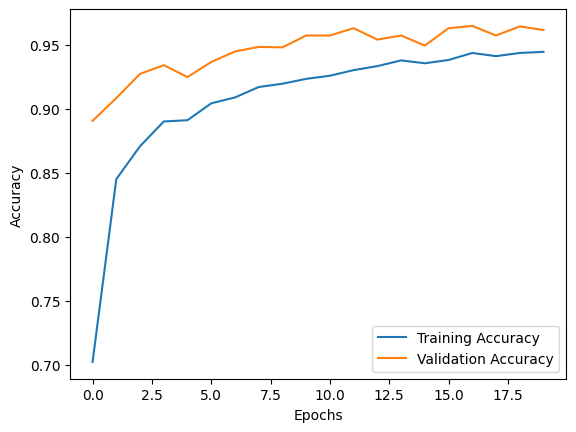

In [ ]:
import matplotlib.pyplot as plt


test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")


model.save("/content/face_mask_cnn.h5")
print("Model saved successfully!")


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:

model.save("face_mask_cnn.h5")
print("Model saved successfully!")


Model saved successfully!


In [ ]:
from google.colab import files


files.download("face_mask_cnn.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>